# CAP 6618 - Machine Learning for Computer Vision

Christian Garbin
Spring 2019

# Programming Project 4
See guidelines on Canvas for details.

## Step 1: Setup

First, make sure that you have installed Keras on your computer.

In [1]:
# Code adapted from https://towardsdatascience.com/transfer-learning-using-keras-d804b2e04ef8

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

/var/web_services/galaxy/jupyter_conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Set up `matplotlib` and `numpy`, used in a few places below.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

## Step 2: Classify images using a pretrained (on ImageNet) model (ResNet50)

In [3]:
# Code adapted from https://keras.io/applications/#resnet50
from keras.applications import resnet50

from keras.preprocessing import image

model = resnet50.ResNet50(weights='imagenet')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

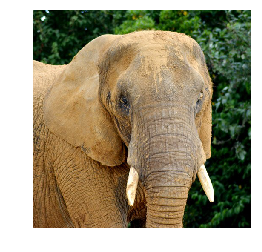

Predicted: [('n02504458', 'African_elephant', 0.87568265), ('n01871265', 'tusker', 0.07350336), ('n02504013', 'Indian_elephant', 0.050809905)]


In [4]:
# Code adapted from https://keras.io/applications/#resnet50

img_path = 'elephant.jpg' #image available on Canvas
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = resnet50.preprocess_input(x)

img=mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', resnet50.decode_predictions(preds, top=3)[0])

## Step 2.1 Try with other images

Keras' ResNet50 model is trained on ImageNet. Image has a collection of [categories and subcategories](http://www.image-net.org/about-stats). In this test we will attempt some (to me) unusual categories. In each case we will try a nice and clean picture (only that category), then a more complicated case, where more objects are part of the picture.

First, some auxiliary functions, based on the code above.

These images were chosen to try to stretch the classifier, and in some cases it did. To make it perform better we should probably first segment the image.

In [5]:
def predict_image_resnet50(img_path):
    # Load image in PIL format
    img = image.load_img(img_path, target_size=(224, 224))
    # Convert to numpy array, channels_last, float32
    x = image.img_to_array(img)
    # Expand dimensions to match the format Keras needs in `predict()`
    # In gist: add one more dimension to hold the batch size (1 image in this case)
    x = np.expand_dims(x, axis=0)
    # Normalize pixel values (zero-centered by mean pixel)
    x = resnet50.preprocess_input(x)
    preds = model.predict(x)
    return preds

def show_image(img_path):
    img = mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()
    

Now show and classify some images.

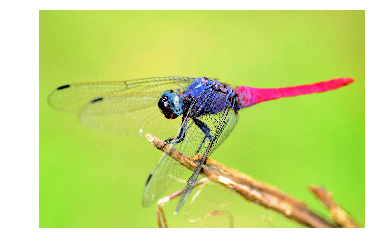

Predicted: [('n02268443', 'dragonfly', 0.986628), ('n02268853', 'damselfly', 0.011298204), ('n02190166', 'fly', 0.001407331)]


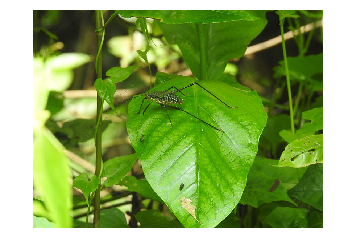

Predicted: [('n01770081', 'harvestman', 0.757915), ('n02168699', 'long-horned_beetle', 0.082648724), ('n02165105', 'tiger_beetle', 0.028612005)]


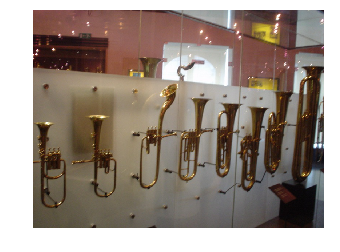

Predicted: [('n03110669', 'cornet', 0.5097316), ('n04090263', 'rifle', 0.12345884), ('n04487394', 'trombone', 0.10348953)]


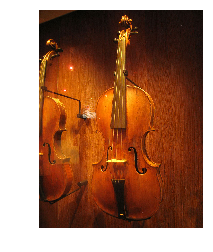

Predicted: [('n02992211', 'cello', 0.8882415), ('n04536866', 'violin', 0.11030497), ('n02787622', 'banjo', 0.0011213009)]


In [6]:
# All images from https://commons.wikimedia.org/wiki/Main_Page
image_paths = [
    # Searched from 'invertebrate'
    # https://commons.wikimedia.org/wiki/File:The_invertebrate.jpg
    # There is only one invertebrate in the picture
    './resnet_test_images/The_invertebrate.jpg',
    # https://commons.wikimedia.org/wiki/File:Invertebrate_Tettigoniidae_(Katydid)_04.jpg
    # Here we have two: lots of plants (leaves) and a bettle
    './resnet_test_images/800px-Invertebrate_Tettigoniidae_(Katydid)_04.jpg',
    
    # Searched for 'musical instrument'
    # https://commons.wikimedia.org/wiki/File:Tuba_Family,_Musical_Instrument_Museum,_Brussels.jpg
    # Lots of the same instrument
    './resnet_test_images/Tuba_Family,_Musical_Instrument_Museum,_Brussels.jpg',
    # https://commons.wikimedia.org/wiki/File:Stringed_instruments_-_Musical_Instrument_Museum,_Brussels_-_IMG_3960.JPG
    # One front and center and a partial one in the back
    './resnet_test_images/Stringed_instruments_-_Musical_Instrument_Museum,_Brussels_-_IMG_3960.JPG'
]

for i in image_paths:
    show_image(i)
    print('Predicted:', resnet50.decode_predictions(predict_image_resnet50(i), top=3)[0])

## Step 3: Load (and split) the dataset

In [7]:
# Code adapted from https://keras.io/datasets/         and 
# https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py

from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [8]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


## Step 4: Visualize a sample of the CIFAR-10 dataset

In [9]:
# See code at https://github.com/rnoxy/cifar10-cnn/blob/master/CIFAR10-visualization.ipynb    and
# http://parneetk.github.io/blog/cnn-cifar10/      for ideas

In [10]:
# Class names as labels (y_train has them as indices only)
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

num_classes = len(class_names)

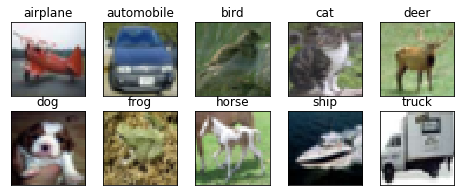

In [11]:
# Based on http://parneetk.github.io/blog/cnn-cifar10/

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Step 5: Classify images using a CNN built from scratch ("Solution 1")

In [12]:
# Code adapted from https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py

from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 32
num_classes = 10
epochs = 10
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


print('Not using data augmentation.')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

# Commented out because we are not loading this model later
# Left here for illustration only
# Save model and weights
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# model_path = os.path.join(save_dir, model_name)
# model.save(model_path)
# print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 29s 581us/step - loss: 1.8285 - acc: 0.3306 - val_loss: 1.5195 - val_acc: 0.4530
Epoch 2/10
50000/50000 [==============================] - 28s 565us/step - loss: 1.4944 - acc: 0.4565 - val_loss: 1.3819 - val_acc: 0.5057
Epoch 3/10
50000/50000 [==============================] - 28s 566us/step - loss: 1.3592 - acc: 0.5145 - val_loss: 1.2630 - val_acc: 0.5557
Epoch 4/10
50000/50000 [==============================] - 29s 577us/step - loss: 1.2606 - acc: 0.5503 - val_loss: 1.1404 - val_acc: 0.5971
Epoch 5/10
50000/50000 [==============================] - 28s 569us/step - loss: 1.1782 - acc: 0.5836 - val_loss: 1.0820 - val_acc: 0.6170
Epoch 6/10
50000/50000 [==============================] - 28s 569us/step - loss: 1.1129 - acc: 0.6088 - val_loss: 1.0184 - val_acc: 0.6441
Epoch 7/10
500

## Step 6 (OPTIONAL): Write code to perform image classification using the weights of a CNN pretrained on the CIFAR-10 dataset "as is" and evaluate it on the CIFAR-10 test set

Suggestions:
1. Download _cifar10vgg.h5_ file available at https://github.com/geifmany/cifar-vgg
2. Look at example at https://keras.io/applications  

## Step 7: Write code to perform data augmentation and evaluate its performance on the CIFAR-10 test set ("Solution 2")

In [13]:
# Based on https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py
# Same as the previous step, but now with the data augmentation code in place
'''
#Train a simple deep CNN on the CIFAR10 small images dataset.
It gets to 75% validation accuracy in 25 epochs, and 79% after 50 epochs.
(it's still underfitting at that point, though).
'''

from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

batch_size = 32
num_classes = 10
epochs = 10  # <---- original code used '100'
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)

# Not needed for this example
# Save model and weights
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# model_path = os.path.join(save_dir, model_name)
# model.save(model_path)
# print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Using real-time data augmentation.
Epoch 1/10
1563/1563 [==============================] - 29s 19ms/step - loss: 1.8476 - acc: 0.3125 - val_loss: 1.5923 - val_acc: 0.4165
Epoch 2/10
1563/1563 [==============================] - 28s 18ms/step - loss: 1.5912 - acc: 0.4181 - val_loss: 1.4077 - val_acc: 0.4848
Epoch 3/10
1563/1563 [==============================] - 28s 18ms/step - loss: 1.4605 - acc: 0.4686 - val_loss: 1.2871 - val_acc: 0.5372
Epoch 4/10
1563/1563 [==============================] - 28s 18ms/step - loss: 1.3771 - acc: 0.5022 - val_loss: 1.2127 - val_acc: 0.5671
Epoch 5/10
1563/1563 [==============================] - 28s 18ms/step - loss: 1.3100 - acc: 0.5306 - val_loss: 1.1474 - val_acc: 0.5948
Epoch 6/10
1563/1563 [==============================] - 28s 18ms/step - loss: 1.2464 - acc: 0.5553 - val_loss: 1.1011 - val_acc: 0.6125
Epoch 7/10
1563/1563 [==============================] - 28s 18ms/step - loss

## Step 8: Write code to use a pretrained CNN model in which an appropriate (fully-connected) layer's activations are used as features, which are then used by a conventional machine learning classifier ("Solution 3")

In [14]:
from keras.applications import vgg19
from keras.preprocessing import image
from keras.models import Model

base_model = vgg19.VGG19(weights='imagenet')
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

The code below uses a VGG19 pre-trained on ImageNet and builds a model whose output is the output of the 'fc2' layer of the original (base) model.  

It then demonstrates how one can run an image through the network and extract a (4096-D) feature vector, effectively using the pre-trained CNN as a "de luxe feature extraction step."

Your job is to change the code below to make all images of the training set undergo the same feature extraction step, and use the resulting feature vectors as input to a conventional classfier.

Once the new classifier has been trained, it should be tested on the test set in the usual way.

In [15]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

# Also tried with fc1 and RandomForestClassifier - see notes in the classifier code
# Accuracy was sligthly better, not by much
# model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

In [16]:
img_path = 'elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = vgg19.preprocess_input(x)

fc2_features = model.predict(x)
fc2_features.shape

(1, 4096)

Reload the dataset. The code in previous steps manipulated the dataset. We can't trust it's in a good shape now.

In [17]:
# The data, split between train and test sets:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


We have to resize the image to match the VGG size of 224 x 224 x 3 (RGB). This code checks if we are resizing it correctly by displaying a resized image.

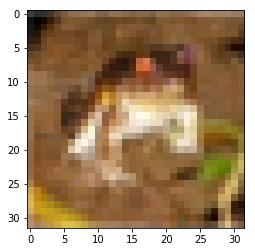

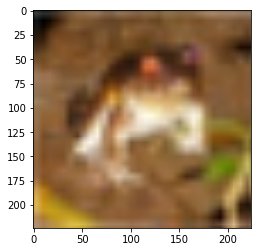

In [18]:
from skimage import transform

# The original image
plt.imshow(x_train[0])
plt.show()

# The scaled image
resized_img = transform.resize(x_train[0], (224, 224, 3), order=1, mode='reflect')
plt.imshow(resized_img)
plt.show()

Function to predict an array of images, including resizing and preprocessing.

Note that the preprocessing step (`preprocess_input`) varies by base model (ResNet50, VGG16, etc.). Hence requiring the name of the Python module for the model as a parameter.

In [19]:
from skimage import transform

def predict_all_images(images, model, base_module, new_size=None):
    print('Predicting {} images'.format(len(images)))

    predictions = []
    for i, img in enumerate(images):
        # Simple progress indicator
        if i % 500 == 0:
            print('{}'.format(i), end=", ")
            
        # Resize, if asked to do so
        if new_size is not None:
            img = transform.resize(img, new_size, order=1, mode='reflect')
            
        # Expand dimensions to match the format Keras needs in `predict()`
        # In gist: add one more dimension to hold the batch size (1 image in this case)
        x = np.expand_dims(img, axis=0)
        
        # Normalize pixel values to what the model was trained one
        # It varies by model - see https://stackoverflow.com/a/47556342
        x = base_module.preprocess_input(x)

        predictions.append(model.predict(x))

    return predictions

### Step 8.1: get predictions for the train and the test datasets, i.e. extract their features

In [20]:
# Set this to True to run quick tests on a smaller train dataset, or False to use the full train dataset

# TODO: ensure this is 'False' for the final test
QUICK_TEST = False

In [21]:
if QUICK_TEST:
    x_train = x_train[:10000]
    y_train = y_train[:10000]
    print('QUICK TEST IS ON - training with {} samples'.format(len(x_train)))

In [22]:
x_train_features = predict_all_images(x_train, model, vgg19, new_size=(224, 224, 3))

Predicting 50000 images
0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 19500, 20000, 20500, 21000, 21500, 22000, 22500, 23000, 23500, 24000, 24500, 25000, 25500, 26000, 26500, 27000, 27500, 28000, 28500, 29000, 29500, 30000, 30500, 31000, 31500, 32000, 32500, 33000, 33500, 34000, 34500, 35000, 35500, 36000, 36500, 37000, 37500, 38000, 38500, 39000, 39500, 40000, 40500, 41000, 41500, 42000, 42500, 43000, 43500, 44000, 44500, 45000, 45500, 46000, 46500, 47000, 47500, 48000, 48500, 49000, 49500, 

Visualize a prediction as 64 x 64 image.

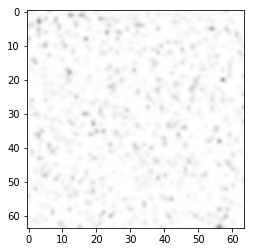

In [23]:
# TODO: improve this code to show several samples for each class

# Bicubic interpolation was chosen so we focus on the patterns more, and less on the individual pixels
plt.imshow(np.reshape(x_train_features[500], (64, 4096//64)), interpolation='bicubic', cmap='Greys')
plt.show()

### Step 8.2: train a standard classifier on the predicted output (the features)

Reshape Keras dataset and prediction results to the format that sklearn classifiers expect.

Labels:

* What we get from the Keras dataset for the training labels: an array with
  50,000 1-element arrays, i.e. (50000, 1)
* What we need for the sklearn classifier: an array with 50,000 elements,
  i.e. (50000)
  
Predicted values:

* What we get from Keras prediction: a list with 50,000 elements, each is a
  1-element array that contains an array of 4096 elements (50000, 1, 4096)
* What we need for the sklearn classifier: an array with 50,000 elements, each
  is an array with 4096 elements (50000, 4096).
  
In other words, we want to "unwrap" the 1-element arrays. This is done with NumPy `squeeze`.

In [24]:
x_train_features = np.asarray(x_train_features)
x_train_features = np.squeeze(x_train_features, axis=1)

y_train = np.squeeze(y_train, axis=1)

Now train a classifier on the reshaped feature array.

In [25]:
%%time

# Slow prediction times, but reasonably accurate
# from sklearn.neighbors import KNeighborsClassifier
# clf = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
# Results:
# # cross_val_score using 10,000 train samples, .resize with order=1 and KNeighborsClassifier:
#    [0.27727818 0.26274745 0.28048048]
# cross_val_score using 10,000 train samples, .resize with order=0 and KNeighborsClassifier:
#    [0.28117506 0.27954409 0.27237237]
# accuracy_score using 50,000 train samples, .resize with order=1 and KNeighborsClassifier:
# (cross_val_score was too slow)
#    0.3087

# Fast(er), but not very accurate
# from sklearn.ensemble import AdaBoostClassifier
# clf = AdaBoostClassifier()

# from sklearn.linear_model import SGDClassifier
# clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, random_state=42)
# accuracy_score using 50,000 train samples, .resize with order=1 and RandomForestClassifier:
#    0.3323
# accuracy_score using 10,000 train samples, .resize with order=1 and RandomForestClassifier:
#    0.3014
#    Training time = 2.5s, test time = 0.2s
# accuracy_score using 10,000 train samples, .resize with order=1 and RandomForestClassifier:
# and **fc1** layer
#    0.3195
#    Training time = 3.7s, test time = 0.09s

# from sklearn.svm import LinearSVC
# clf = LinearSVC()
# accuracy_score using 10,000 train samples, .resize with order=1 and LinearSVC:
#    0.2773
#    Training time = 6.5min, test time = 0.9s

fit_results = clf.fit(x_train_features, y_train)
print(fit_results)  # Need to explicitly print results because of %%time

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
CPU times: user 16.3 s, sys: 438 ms, total: 16.7 s
Wall time: 16.5 s


### Step 8.3: evalute the classifier

Cross-validation scores on the training data.

In [26]:
%%time
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, x_train_features, y_train, cv=3, scoring="accuracy")
print(scores)

[0.32231554 0.32639472 0.32533013]
CPU times: user 30.6 s, sys: 896 ms, total: 31.5 s
Wall time: 31.1 s


Confusion matrix for the cross-validated scores.

In [27]:
%%time
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Predict every single instance in the training data
y_train_pred = cross_val_predict(clf, x_train_features, y_train, cv=3, n_jobs=-1)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

[[2308  459  338  195  129  149  115  157  874  276]
 [ 546 2134  229  260  167  160  249  240  380  635]
 [ 549  337 1435  527  661  462  481  208  200  140]
 [ 331  407  728  970  638  753  453  365   98  257]
 [ 255  327  897  570 1315  461  568  360   86  161]
 [ 226  314  644  846  519 1396  326  478   67  184]
 [ 226  476  727  528  663  343 1561  210   78  188]
 [ 312  433  443  565  488  593  292 1401   77  396]
 [1098  569  216  129  122   93   71   81 2270  351]
 [ 603 1024  211  341  139  212  203  428  395 1444]]
CPU times: user 5.12 s, sys: 980 ms, total: 6.09 s
Wall time: 17.3 s


Confusion-matrix in graphical format.

Lighter colors = higher values = better classification performance.

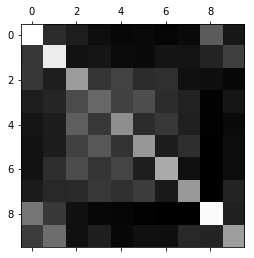

In [28]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Accuracy on the test data.

First extract the features from the test instances and reshape them. That's the input for the classifier, just like it was done for the train data.

In [29]:
%%time

x_test_features = predict_all_images(x_test, model, vgg19, new_size=(224, 224, 3))

x_test_features = np.asarray(x_test_features)
x_test_features = np.squeeze(x_test_features, axis=1)

Predicting 10000 images
0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, CPU times: user 2min 38s, sys: 7.82 s, total: 2min 46s
Wall time: 8min 23s


In [30]:
%%time
from sklearn.metrics import accuracy_score

y_pred = clf.predict(x_test_features)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)  # Need to explicitly print because of %%time

0.3352
CPU times: user 96.4 ms, sys: 1.9 ms, total: 98.3 ms
Wall time: 95.8 ms


### Analysis and conclusions

The traditional classifier performed poorly when used the extracted features. 

The likely reason for that is the use of the dense layer. As explained in Deep Learning with Python
(Chollet), chapter 5:

> Could you reuse the densely connected classifier as well? In general, doing so should be avoided.
> The reason is that the representations learned by the convolutional base are likely to be more
> generic and therefore more reusable: the feature maps of a convnet are presence maps of generic
> concepts over a picture, which is likely to be useful regardless of the computer-vision problem
> at hand. But the representations learned by the classifier will necessarily be specific to the
> set of classes on which the model was trained—they will only contain information about the presence
> probability of this or that class in the entire picture.

## Step 9: Write code to use a pretrained CNN model with the proper modifications (and retraining) to one or more layers ("Solution 4")

Based on the conclusions from the previous step, in this step we will use the last convolutional layer of a CNN network to extract features.

This section is based on Chollet's "Deep Learning with Python", chapter 5.

### Step 9.1: Load the base network, without the dense layers

The base network is Keras' pretrained VGG16.

Not that `input_shape` is not specified. If we attempt to specify the CIFAR-10 shape (32, 32), it fails because the minimum value it accepts is (48, 48). Not specifying an input shape allows us to use images of any size, thus allowing us to use the CIFAR-10 (32, 32) size without any resizing.

In [31]:
from keras.applications import vgg16

conv_base = vgg16.VGG16(weights='imagenet', include_top=False)
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### Step 9.2: Load and prepare the dataset

Reload the dataset. The code in previous steps manipulated the dataset. We can't trust it's in a good shape now.

In [32]:
# The data, split between train and test sets:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


Keras' CIFAR-10 is stored as integer. Later pieces of code need the data in float type.

In [33]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

Since we are using a neural network, we need to convert the categories from labels (numbers) to a hot-encoded vector. See [this article](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) on why we need to hot-encode in this case.

In [34]:
from keras.utils import to_categorical

num_classes = len(np.unique(y_train))
print('Hot-enconding {} classes'.format(num_classes))

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

Hot-enconding 10 classes


### Step 9.3: Extract features

Extract the features from the training set. Note that we are reusing the functions we defined in step 8.

Since this is the most time consuming step of the transfer learning process, we will save the results to a file and attempt to restore from that file before calculating the predictions agian. 

**IMPORTANT:** if anything changes in the prediction process (e.g. a different base network configuration), remember to erase the files to force new predictions to be calculated.

In [35]:
import os
import pickle

def calculate_predictions(dataset, file_name):
    if os.path.isfile(file_name):
        print('Loading predictions from {}'.format(file_name))
        with open (file_name, 'rb') as fp:
            features = pickle.load(fp)
    else:
        features = predict_all_images(dataset, conv_base, vgg16, new_size=None)
        with open(file_name, 'wb') as fp:
            pickle.dump(features, fp)

    return features

In [36]:
%%time
x_train_features = calculate_predictions(x_train, 'predicted_train_features')

Predicting 50000 images
0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 19500, 20000, 20500, 21000, 21500, 22000, 22500, 23000, 23500, 24000, 24500, 25000, 25500, 26000, 26500, 27000, 27500, 28000, 28500, 29000, 29500, 30000, 30500, 31000, 31500, 32000, 32500, 33000, 33500, 34000, 34500, 35000, 35500, 36000, 36500, 37000, 37500, 38000, 38500, 39000, 39500, 40000, 40500, 41000, 41500, 42000, 42500, 43000, 43500, 44000, 44500, 45000, 45500, 46000, 46500, 47000, 47500, 48000, 48500, 49000, 49500, CPU times: user 7min 7s, sys: 41.8 s, total: 7min 49s
Wall time: 7min 6s


Extract features from the test set.

In [37]:
%%time
x_test_features = calculate_predictions(x_test, 'predicted_test_features')

Predicting 10000 images
0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, CPU times: user 1min 25s, sys: 8.4 s, total: 1min 33s
Wall time: 1min 25s


### Step 9.4 Reshape to fit the input layer of the next network

We now have features stored in a list. Before we fed them into the next network, we need to adapt their type and shape:

- Use a NumPy array instead of list
- Ensure it has four dimensions

The last step is is not strictly needed. We could make the first layer in the next network use whatever dimension we have, but it's more common to have four dimensions as an output of a convolutional layer, as we can see for the last layer of the base VGG16 network created above:

`block5_pool (MaxPooling2D)   (None, None, None, 512)   0    `

In [38]:
x_train_features = np.asarray(x_train_features)
x_test_features = np.asarray(x_test_features)

print(x_train_features.shape)
print(x_test_features.shape)

(50000, 1, 1, 1, 512)
(10000, 1, 1, 1, 512)


In [39]:
# Remove the extra encapsulating array
x_train_features = np.squeeze(x_train_features, axis=1)
x_test_features = np.squeeze(x_test_features, axis=1)

print(x_train_features.shape)
print(x_test_features.shape)

(50000, 1, 1, 512)
(10000, 1, 1, 512)


### Step 9.5: Train the final classifier on the extracted features

Create the classifier.

A few observations from experiments:

- Batch normalization resulted in better accuracy than dropout
- Learning rate can be reasonably high, thanks to batch normalization, resulting in convergence after a few epochs
- Small dense layers performed nearly as well as large dense layers (> 1024) and are faster to train

In [40]:
from keras import models
from keras import layers
from keras import optimizers 
from keras import losses

model = models.Sequential()
model.add(Flatten(input_shape=(1, 1, 512,)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.categorical_crossentropy,
              metrics=['accuracy'])

Train the classifier, using early stopping to get a good accuracy without much guessing.

In [41]:
from keras import callbacks

early_stopping = callbacks.EarlyStopping(monitor='val_acc', patience=2, verbose=1)

history = model.fit(x_train_features, y_train,
                    epochs=100, 
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 9s 206us/step - loss: 1.1767 - acc: 0.5944 - val_loss: 0.9909 - val_acc: 0.6608
Epoch 2/100
45000/45000 [==============================] - 9s 190us/step - loss: 0.9956 - acc: 0.6524 - val_loss: 0.9623 - val_acc: 0.6696
Epoch 3/100
45000/45000 [==============================] - 9s 190us/step - loss: 0.9484 - acc: 0.6670 - val_loss: 0.9538 - val_acc: 0.6768
Epoch 4/100
45000/45000 [==============================] - 9s 192us/step - loss: 0.9191 - acc: 0.6760 - val_loss: 0.9368 - val_acc: 0.6868
Epoch 5/100
45000/45000 [==============================] - 9s 190us/step - loss: 0.8979 - acc: 0.6866 - val_loss: 0.9383 - val_acc: 0.6870
Epoch 6/100
45000/45000 [==============================] - 9s 190us/step - loss: 0.8685 - acc: 0.6967 - val_loss: 0.9422 - val_acc: 0.6852
Epoch 7/100
45000/45000 [==============================] - 9s 190us/step - loss: 0.8547 - acc: 0.7009 - val_loss: 0.9

### Step 9.6: Evaluate the final classifier

Check the training history.

In [42]:
# Adapted from https://keras.io/visualization/ - changed to side-by-side plots to save space
from matplotlib.ticker import MaxNLocator

def plot_keras_history(history):

    # Side-by-side plots, wider than taller, to make run for the epochs
    f = plt.figure(figsize=(12,4))
    ax_acc = f.add_subplot(121)
    ax_loss = f.add_subplot(122)

    # Plot training & validation accuracy values
    ax_acc.plot(history.history['acc'])
    ax_acc.plot(history.history['val_acc'])
    ax_acc.set_title('Model accuracy')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.set_xlabel('Epoch')
    ax_acc.legend(['Train', 'Test'], loc='upper left')
    ax_acc.xaxis.set_major_locator(MaxNLocator(integer=True))

    # Plot training & validation loss values
    ax_loss.plot(history.history['loss'])
    ax_loss.plot(history.history['val_loss'])
    ax_loss.set_title('Model loss')
    ax_loss.set_ylabel('Loss')
    ax_loss.set_xlabel('Epoch')
    ax_loss.legend(['Train', 'Test'], loc='upper left')
    ax_loss.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()

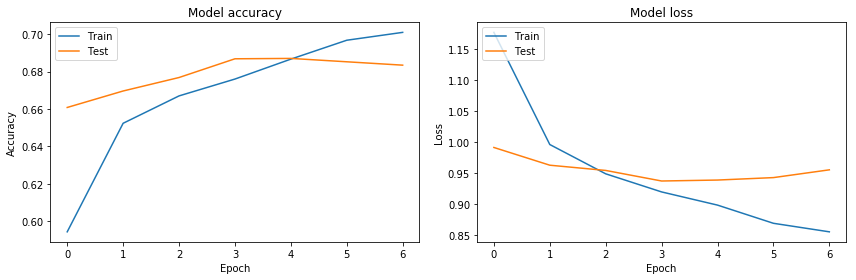

In [43]:
plot_keras_history(history)

Check accuracy on the test dataset.

In [44]:
# scores = model.evaluate(x_test_features_flat, y_test, verbose=1)
scores = model.evaluate(x_test_features, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 1s 63us/step
Test loss: 0.9721496367454528
Test accuracy: 0.6762


## Step 10: Build your best solution (and explain each step) 

## Use a separate notebook